In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import TensorDataset, DataLoader

In [2]:
import matplotlib.pyplot as plt

In [3]:
from PIL import Image

In [14]:
import sys
sys.path.append("../figures")

from where import RetinaFill, CollFill, WhereShift, RetinaBackground, RetinaMask, RetinaWhiten 
from where import RetinaTransform, WhereNet, CollTransform, MNIST, Normalize, WhereTrainer, Where
from where import FullfieldRetinaWhiten, FullfieldRetinaTransform, FullfieldToFloatTensor

In [5]:
from main import init
args = init(filename='../data/2019-06-13')
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'N_pic': 128,
 'offset_std': 15,
 'offset_max': 40,
 'noise': 1.0,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.5,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.0001,
 'do_adam': True,
 'bn1_bn_momentum': 0.0,
 'bn2_bn_momentum': 0.0,
 'momentum': 0.0,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': True,
 'log_interval': 100,
 'verbose': 1,
 'filename': '../data/2019-06-13',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True}

In [6]:
from retina import Retina
retina = Retina(args)

In [7]:
accuracy_map = np.load('../data/MNIST_accuracy.npy')

In [8]:
accuracy_map.shape
27 + 28

55

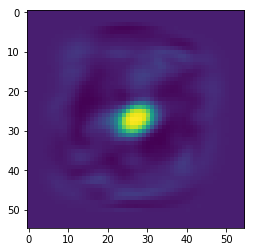

In [9]:
plt.imshow(accuracy_map)

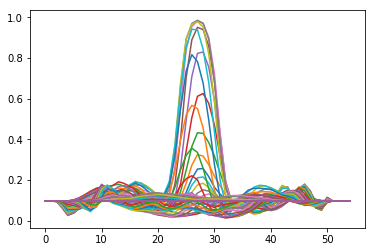

In [10]:
_ = plt.plot(accuracy_map)

## Unit tests

In [11]:
import math

In [12]:
i_offset = -18 #None #
j_offset = 18 #None #

In [80]:
args.contrast = 0.7

In [81]:
fullfield_transform = transforms.Compose([
            RetinaFill(N_pic=args.N_pic),
            WhereShift(args, i_offset=-15, j_offset=15),
            RetinaBackground(contrast=args.contrast,
                             noise=args.noise,
                             sf_0=args.sf_0,
                             B_sf=args.B_sf),
            RetinaMask(N_pic=args.N_pic),
            FullfieldRetinaWhiten(N_pic=args.N_pic),
            FullfieldRetinaTransform(retina.retina_transform_vector),
            FullfieldToFloatTensor(),
            # Normalize(fullfield=True)
            # transforms.Normalize((args.mean,), (args.std,))
        ])

In [82]:
dataset_display = MNIST('../data',
                        train=False,
                        download=True,
                        transform=fullfield_transform
                        )

In [83]:
display_loader = torch.utils.data.DataLoader(dataset_display,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [84]:
data, label = next(iter(display_loader))

In [85]:
data_fullfield = data[1]

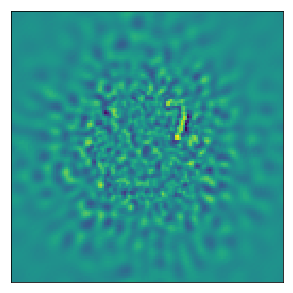

In [86]:
idx = 5
data_retina = retina.retina(data_fullfield[idx, :, :])
fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(111)
ax = retina.show(ax, retina.retina_invert(data_retina), do_cross=False)
fig.savefig('../tmp/CNS-contrast-' +str(args.contrast)+ '.png', bbox_inches='tight', pad_inches=0.1)

In [14]:
transform=transforms.Compose([
                               RetinaFill(N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4), 
                               #WhereShift(args, radius = 18), 
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset),
                               RetinaBackground( contrast=args.contrast,
                                                 noise=args.noise,
                                                 sf_0=args.sf_0,
                                                 B_sf=args.B_sf),
                               RetinaMask(N_pic=args.N_pic),
                               RetinaWhiten(N_pic=args.N_pic),
                               RetinaTransform(retina.retina_transform_vector),
                               #Normalize()
                           ])

In [15]:
target_transform=transforms.Compose([
                               CollFill(accuracy_map=accuracy_map, N_pic=args.N_pic),
                               #WhereShift(args, theta=3*math.pi/4, baseline = 0.1),
                               #WhereShift(args, radius = 18, baseline = 0.1),
                               WhereShift(args, i_offset=i_offset, j_offset=j_offset, baseline = 0.1),
                               CollTransform(retina.colliculus_transform_vector),
                           ])

In [16]:
dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

NameError: name 'transform' is not defined

In [17]:
len(dataset_train)

60000

In [38]:
train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [39]:
dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        target_transform = target_transform,
                        )

In [40]:
len(dataset_test)

10000

In [41]:
test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [42]:
data, label = next(iter(train_loader))

In [43]:
data.shape

torch.Size([100, 128, 128])

In [44]:
np.max((np.array([1, 2, 3]),np.array([3, 2, 1])), axis=0)

array([3, 2, 3])

In [45]:
#plt.imshow(data[i,:,:].detach().numpy())

In [46]:
label.shape

torch.Size([100, 240])

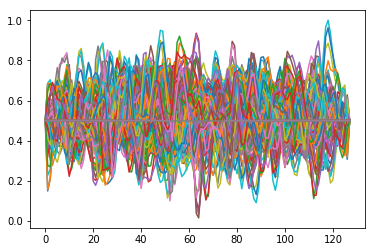

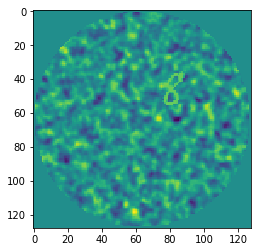

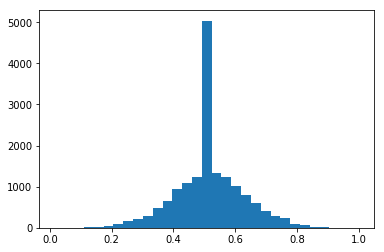

In [47]:
i = 4
_ = plt.plot(data[i,:].detach().numpy())
plt.show()
plt.imshow(data[i,:])
plt.show()
_ = plt.hist(data[i,:].detach().numpy().flatten(),31)

In [27]:
#plt.imshow(retina.retina_invert(data[i,:].detach().numpy()))
plt.plot(data[i,:].detach().numpy())

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 128 is different from 2880)

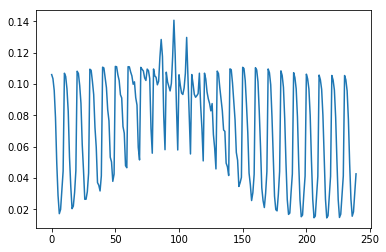

In [28]:
plt.plot(label[i,:].detach().numpy())

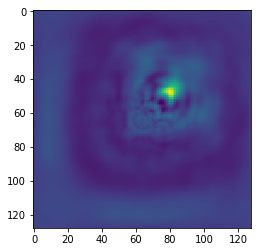

In [29]:
plt.imshow(retina.accuracy_invert(label[i,:].detach().numpy()))

(array([ 366.,  911., 1854., 2730., 3025., 5898., 1055.,  362.,  165.,
          18.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

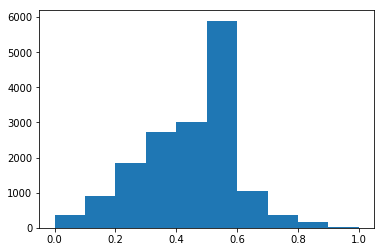

In [30]:
plt.hist(data[i,:].detach().numpy().flatten())

## WhereTrainer Class test

In [51]:
whereTrainer = WhereTrainer(args, generate_data=False)

Retina vectorizing...
ok
success
Done vectorizing...
Inversing retina transform...
Done Inversing retina transform...
BN1 is on
BN2 is on


In [53]:
whereTrainer.model

WhereNet(
  (bn1): Linear(in_features=2880, out_features=1000, bias=True)
  (bn1_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn2): Linear(in_features=1000, out_features=1000, bias=True)
  (bn2_bn): BatchNorm1d(1000, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
  (bn3): Linear(in_features=1000, out_features=240, bias=True)
)

### Dataloader tests

#### TrainLoader

In [54]:
data, label = next(iter(whereTrainer.train_loader))

In [ ]:
data_test, label_test = next(iter(train_loader))

In [ ]:
len(whereTrainer.train_loader.dataset)

In [ ]:
len(whereTrainer.test_loader.dataset)

In [ ]:
i = 3
plt.imshow(whereTrainer.retina.retina_invert(data_test[i,:].detach().numpy()))
plt.show()
plt.imshow(whereTrainer.retina.accuracy_invert(label_test[i,:].detach().numpy()))
plt.show()

#### TestLoader

In [ ]:
data, data_fullfield, acc, acc_fullfield, labels = next(iter(whereTrainer.test_loader))

In [ ]:
for batch_idx, (data, data_fullfield, acc, acc_fullfield, labels) in enumerate(whereTrainer.test_loader):
    print(batch_idx)

In [ ]:
i = 3
plt.plot(data[i,:].detach().numpy())
plt.plot(data_test[i,:].detach().numpy())
plt.show()
plt.plot(acc[i,:].detach().numpy())
plt.plot(label_test[i,:].detach().numpy())
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data[i,:].detach().numpy()))
plt.title(labels[i].detach().numpy())
plt.show()
plt.imshow(data_fullfield[i,:].detach().numpy())
plt.show()
plt.imshow(whereTrainer.retina.accuracy_invert(acc[i,:].detach().numpy()))
plt.show()
plt.imshow(acc_fullfield[i,:].detach().numpy())
plt.show()

### Filters tests

In [31]:
data.shape

torch.Size([100, 128, 128])

In [32]:
acc.min()

NameError: name 'acc' is not defined

In [33]:
data_float = data.float()

In [34]:
data_double = data_float.double()

In [35]:
data_np = data [i,:].detach().numpy()

In [36]:
data_float_np = data_float[i,:].detach().numpy()

In [37]:
data_double_np = data_double[i,:].detach().numpy()

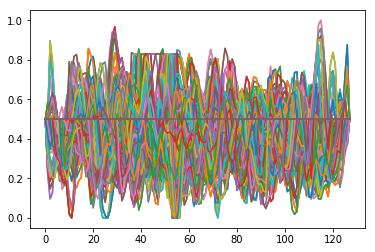

NameError: name 'whereTrainer' is not defined

In [38]:
i = 0
plt.plot(data[i,:].detach().numpy())
plt.plot(data_float[i,:].detach().numpy())
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data[i,:].detach().numpy()))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_float[i,:].detach().numpy()))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_double[i,:].detach().numpy()))


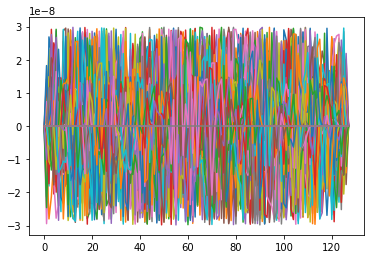

NameError: name 'whereTrainer' is not defined

In [39]:
i = 0
diff = data_np - data_float_np
plt.plot(diff)
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np + 1e-10))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np + diff))
plt.show()
plt.imshow(whereTrainer.retina.retina_invert(data_np + diff * 1e-5))


In [ ]:
whereTrainer.retina.retina_inverse_transform.shape
plt.plot(whereTrainer.retina.retina_inverse_transform[0,:])
#plt.plot(whereTrainer.retina.retina_inverse_transform.flatten())


(2880, 16384)
(16384,)
0.03466796875


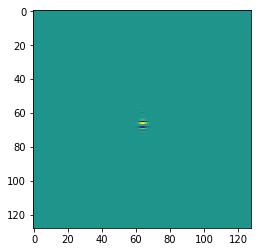

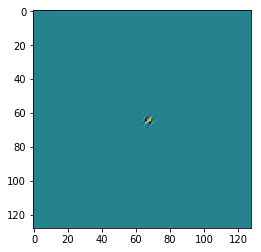

In [59]:
i = 0
print(whereTrainer.retina.retina_transform_vector.shape)
filter_test = whereTrainer.retina.retina_transform_vector[i,:]
print(filter_test.shape)
print(sum(abs(filter_test) > 1e-3) / (128*128))
#plt.plot(whereTrainer.retina.retina_inverse_transform.flatten())
plt.show()
plt.imshow(filter_test.reshape((128, 128)))
plt.show()
plt.imshow(whereTrainer.retina.retina_transform[5,5,1,0,:].reshape((128, 128)))

### Model  test

In [ ]:
output = whereTrainer.model(torch.FloatTensor(data.float()).to('cpu'))

In [ ]:
output.shape

In [ ]:
output.max()

In [ ]:
loss_func = torch.nn.BCEWithLogitsLoss()
loss = loss_func(output, label)

In [ ]:
whereTrainer.loss_func

In [ ]:
whereTrainer.optimizer

In [ ]:
if False:
    from where import train, test
    test(args, 
          whereTrainer.model, 
          "cpu", 
          whereTrainer.test_loader, 
          whereTrainer.loss_func) #, 
          #whereTrainer.optimizer, 
          #1)

In [ ]:
if True:
    for epoch in range(1, args.epochs + 1):
        whereTrainer.train(epoch)
        whereTrainer.test()

In [ ]:
from where import where_suffix
suffix = where_suffix(args)
model_path = '/tmp/where_model_{}.pt'.format(suffix)
torch.save(whereTrainer.model, model_path) 
print('Model saved at', model_path)

In [ ]:
whereTrainer.test()

## Where Tests

In [ ]:
where = Where(args, generate_data=True, trainer=whereTrainer)

In [ ]:
where.test()

## Dataset generation

In [ ]:
if False:
    for i, (data, label) in enumerate(train_loader):
        print(i, (i+1) * args.minibatch_size)
        if i == 0:
            full_data = data
            full_label = label
        else:
            full_data = torch.cat((full_data, data), 0)
            full_label = torch.cat((full_label, label), 0)

In [ ]:
dataset = TensorDataset(full_data, full_label)
data_loader = DataLoader(dataset, batch_size=args.minibatch_size)

In [ ]:
full_data.shape

In [ ]:
data, label = next(iter(data_loader))

In [ ]:
data.shape

In [ ]:
plt.plot(label[i,:].detach().numpy())

In [ ]:
np.random.seed(26722)
np.random.randn()

In [ ]:
from display import pe, minmax
minmax(-15, 10)